<a href="https://colab.research.google.com/github/ubermenchh/jax-sandbox/blob/main/FashionMNIST_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q flax
!pip install -qU jax[tpu] -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.5.0 which is incompatible.


In [2]:
import jax

jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [3]:
batch_size = 32

In [4]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [5]:
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

In [6]:
train_ds = FashionMNIST(root="./train/", train=True, download=True, transform=tfm)
test_ds = FashionMNIST(root="./valid/", train=False, download=True, transform=tfm)

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.1MB/s]


Extracting ./train/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./train/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]


Extracting ./train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./train/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.08MB/s]


Extracting ./train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./train/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.60MB/s]


Extracting ./train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./train/FashionMNIST/raw



100%|██████████| 26.4M/26.4M [00:01<00:00, 17.1MB/s]


Extracting ./valid/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./valid/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 274kB/s]


Extracting ./valid/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./valid/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.10MB/s]


Extracting ./valid/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./valid/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.23MB/s]

Extracting ./valid/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./valid/FashionMNIST/raw



In [7]:
train_ds.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

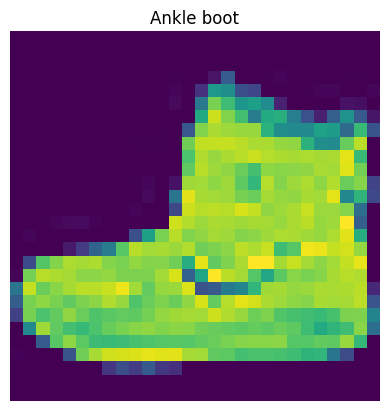

In [8]:
plt.imshow(train_ds[0][0].permute(1, 2, 0))
plt.title(train_ds.classes[train_ds[0][1]])
plt.axis("off");

In [9]:
import numpy as np
import jax.numpy as jnp

def jax_collate(batch):
    images, labels = zip(*batch)
    images = jnp.array(images)
    labels = jnp.array(labels)
    return images, labels

In [10]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0, collate_fn=jax_collate, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0, collate_fn=jax_collate, pin_memory=True)

In [11]:
b = next(iter(train_loader))

In [12]:
b[0].shape, b[1].shape

((32, 1, 28, 28), (32,))

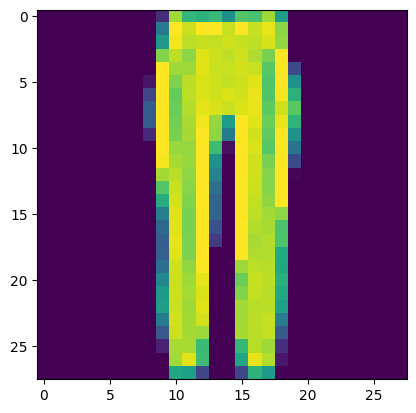

In [13]:
plt.imshow(b[0][0].transpose(1, 2, 0))

In [14]:
from flax import nnx
from functools import partial

In [15]:
class CNN(nnx.Module):
    def __init__(self, *, rngs: nnx.Rngs):
        self.conv1 = nnx.Conv(1, 32, kernel_size=(3, 3), rngs=rngs)
        self.conv2 = nnx.Conv(32, 64, kernel_size=(3, 3), rngs=rngs)
        self.avg_pool = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
        self.linear1 = nnx.Linear(3136, 256, rngs=rngs)
        self.linear2 = nnx.Linear(256, 10, rngs=rngs)

    def __call__(self, x):
        x = x.transpose(0, 2, 3, 1)
        x = self.avg_pool(nnx.relu(self.conv1(x)))
        x = self.avg_pool(nnx.relu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1)
        x = nnx.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [16]:
model = CNN(rngs=nnx.Rngs(0))
nnx.display(model)

CNN(
  conv1=Conv(
    kernel_shape=(3, 3, 1, 32),
    kernel=Param(
      value=Array(shape=(3, 3, 1, 32), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    in_features=1,
    out_features=32,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_dilation=1,
    kernel_dilation=1,
    feature_group_count=1,
    use_bias=True,
    mask=None,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x7c90f01279a0>,
    bias_init=<function zeros at 0x7c9a2555df30>,
    conv_general_dilated=<function conv_general_dilated at 0x7c9a25c1de10>
  ),
  conv2=Conv(
    kernel_shape=(3, 3, 32, 64),
    kernel=Param(
      value=Array(shape=(3, 3, 32, 64), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    in_features=32,
    out_features=64,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_di

In [17]:
import jax.numpy as jnp

y = model(jnp.ones((1, 1, 28, 28)))
nnx.display(y)

[[-0.06906591 -0.14700411  0.00307468 -0.21673903  0.16659853 -0.00916369
  -0.06691957  0.2841027   0.33808973 -0.20155168]]


In [18]:
inp = jnp.ones((1, 1, 28, 28))
inp.shape, inp.transpose(0, 2, 3, 1).shape

((1, 1, 28, 28), (1, 28, 28, 1))

In [19]:
import optax

lr = 0.001
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(lr, momentum))
metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average("loss")
)

nnx.display(optimizer)

Optimizer(
  step=OptState(
    value=Array(0, dtype=uint32)
  ),
  model=CNN(
    conv1=Conv(
      kernel_shape=(3, 3, 1, 32),
      kernel=Param(
        value=Array(shape=(3, 3, 1, 32), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(32,), dtype=float32)
      ),
      in_features=1,
      out_features=32,
      kernel_size=(3, 3),
      strides=1,
      padding='SAME',
      input_dilation=1,
      kernel_dilation=1,
      feature_group_count=1,
      use_bias=True,
      mask=None,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x7c90f01279a0>,
      bias_init=<function zeros at 0x7c9a2555df30>,
      conv_general_dilated=<function conv_general_dilated at 0x7c9a25c1de10>
    ),
    conv2=Conv(
      kernel_shape=(3, 3, 32, 64),
      kernel=Param(
        value=Array(shape=(3, 3, 32, 64), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(64

In [20]:
def loss_fn(model: CNN, batch):
    logits = model(batch[0])
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch[1]).mean()
    return loss, logits

@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch[1])
    optimizer.update(grads)

@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
    loss, logits = loss_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch[1])

In [21]:
metrics_history = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}

train_steps = 200
eval_every = 20

In [22]:
for step in range(train_steps):
    batch = next(iter(train_loader))

    train_step(model, optimizer, metrics, batch)

    if step > 0 and (step % eval_every == 0 or step == train_steps - 1):
        for metric, value in metrics.compute().items():
            metrics_history[f"train_{metric}"].append(value)
        metrics.reset()

        for test_batch in test_loader:
            eval_step(model, metrics, test_batch)

        for metric, value in metrics.compute().items():
            metrics_history[f"test_{metric}"].append(value)
        metrics.reset()

        print(
            f"[train] step: {step}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
        )
        print(
            f"[test] step: {step}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
        )

[train] step: 20, loss: 1.2076935768127441, accuracy: 57.58928680419922
[test] step: 20, loss: 0.8621512055397034, accuracy: 69.47115325927734
[train] step: 40, loss: 0.7614772319793701, accuracy: 70.46875
[test] step: 40, loss: 0.7211575508117676, accuracy: 72.43589782714844
[train] step: 60, loss: 0.5861364603042603, accuracy: 78.90625
[test] step: 60, loss: 0.6608791351318359, accuracy: 74.12860107421875
[train] step: 80, loss: 0.61822110414505, accuracy: 78.4375
[test] step: 80, loss: 0.5932493805885315, accuracy: 78.42547607421875
[train] step: 100, loss: 0.5666660666465759, accuracy: 79.21875
[test] step: 100, loss: 0.5680764317512512, accuracy: 79.00640869140625
[train] step: 120, loss: 0.5980011820793152, accuracy: 78.125
[test] step: 120, loss: 0.6407665014266968, accuracy: 73.51762390136719
[train] step: 140, loss: 0.6504970192909241, accuracy: 75.3125
[test] step: 140, loss: 0.5592563152313232, accuracy: 80.58894348144531
[train] step: 160, loss: 0.5365768671035767, accuracy

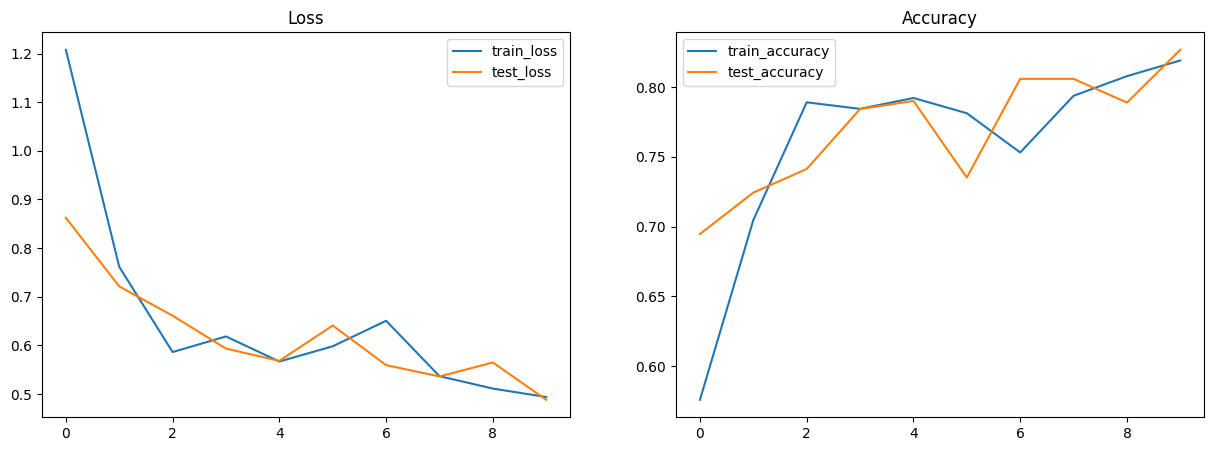

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

In [24]:
model.eval() # Switch to evaluation mode.

@nnx.jit
def pred_step(model: CNN, batch):
  logits = model(batch[0])
  return logits.argmax(axis=1)

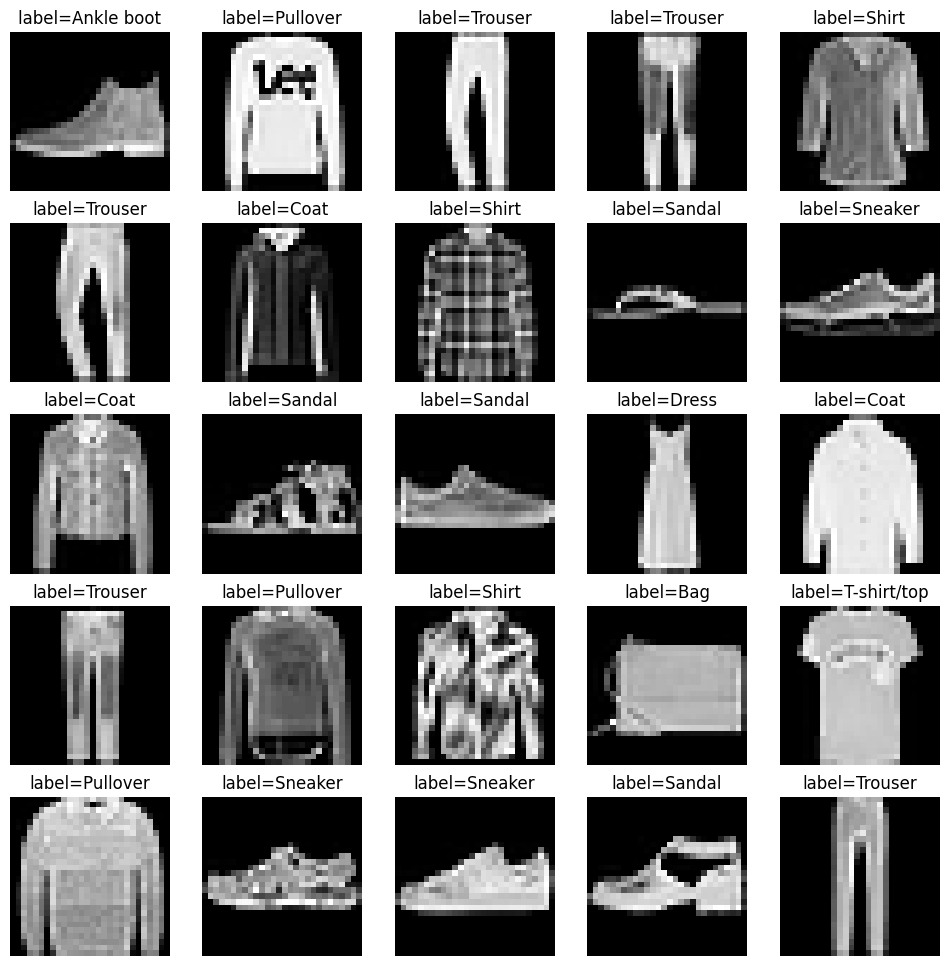

In [25]:
test_batch = next(iter(test_loader))
pred = pred_step(model, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(test_batch[0][i].transpose(1, 2, 0), cmap='gray')
  ax.set_title(f'label={train_ds.classes[pred[i]]}')
  ax.axis('off')